In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

import irbasis3
from numpy.polynomial.legendre import leggauss
from itertools import product

import sys
sys.path.insert(0, "../src/")

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax import grad, jit

In [4]:
from spmomega.solver import MultiOrbitalSolver
from spmomega.quad import composite_leggauss, scale_quad

In [5]:
wmax = 10.0
beta = 10.0
lambda_ = wmax * beta
K = irbasis3.KernelFFlat(lambda_)
basis = irbasis3.FiniteTempBasis(K, "F", beta, eps=1e-15)

In [6]:
solver = MultiOrbitalSolver(basis)
print(solver.smpl_points)

[-10.          -9.95991984  -9.91983968  -9.87975952  -9.83967936
  -9.7995992   -9.75951904  -9.71943888  -9.67935872  -9.63927856
  -9.5991984   -9.55911824  -9.51903808  -9.47895792  -9.43887776
  -9.3987976   -9.35871743  -9.31863727  -9.27855711  -9.23847695
  -9.19839679  -9.15831663  -9.11823647  -9.07815631  -9.03807615
  -8.99799599  -8.95791583  -8.91783567  -8.87775551  -8.83767535
  -8.79759519  -8.75751503  -8.71743487  -8.67735471  -8.63727455
  -8.59719439  -8.55711423  -8.51703407  -8.47695391  -8.43687375
  -8.39679359  -8.35671343  -8.31663327  -8.27655311  -8.23647295
  -8.19639279  -8.15631263  -8.11623246  -8.0761523   -8.03607214
  -7.99599198  -7.95591182  -7.91583166  -7.8757515   -7.83567134
  -7.79559118  -7.75551102  -7.71543086  -7.6753507   -7.63527054
  -7.59519038  -7.55511022  -7.51503006  -7.4749499   -7.43486974
  -7.39478958  -7.35470942  -7.31462926  -7.2745491   -7.23446894
  -7.19438878  -7.15430862  -7.11422846  -7.0741483   -7.03406814
  -6.99398

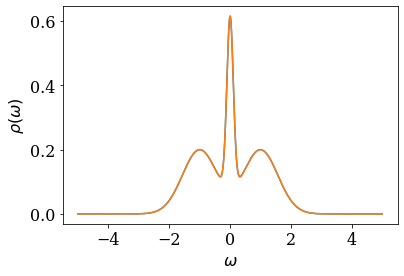

In [7]:
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))

b_smpl = np.sqrt(rho(solver.smpl_points))[:,None,None]
plt.plot(omegas, solver.interpolate(b_smpl, omegas)[:,0,0])

In [8]:
rho_smpl = rho(solver.smpl_points)[:,None,None]
rho_l = solver.rho_l(np.sqrt(rho_smpl))

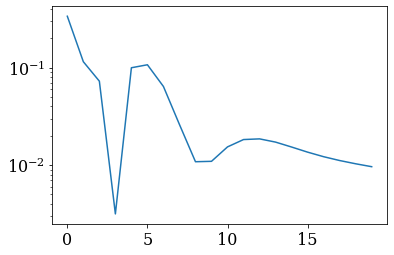

In [9]:
plt.semilogy(np.abs(rho_l[::2,0,0]))

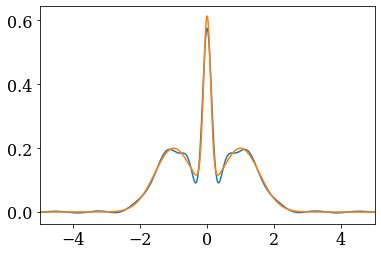

In [10]:
omegas = np.linspace(-wmax, wmax, 1000)
plt.xlim([-5,5])
plt.plot(omegas, np.einsum("lw,l->w", basis.v(omegas), rho_l[:,0,0]))
plt.plot(omegas, rho(omegas))

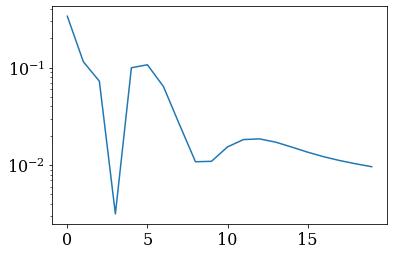

In [11]:
# Expand the spectral function in IR
x_, w_ = leggauss(10000)
x, w = scale_quad(x_, w_, -wmax, wmax)
all_l = np.arange(basis.s.size)

rhol = np.einsum('lw,w,w->l', basis.v.value(all_l[:,None], x[None,:]), w, rho(x), optimize=True)
gl = - basis.s * rhol

plt.semilogy(np.abs(rhol)[::2])

In [29]:
#b_smpl0 = 1e-2*np.random.randn(solver.smpl_points.size,1,1) + 0j*np.random.randn(solver.smpl_points.size,1,1)
b_smpl0 = 1e-2 * np.ones((solver.smpl_points.size, 1, 1)) + 1e-5*np.random.randn(solver.smpl_points.size,1,1) + 0j*np.random.randn(solver.smpl_points.size,1,1)
#b_smpl0 = b_smpl
#b_smpl0 = np.2qrt(rho(solver.smpl_points))[:,None,None]
#b_smpl0 = b_smpl0 + 1j*np.random.randn(solver.smpl_points.size,1,1) * 1e-5
b_smpl_reconst0 = solver.fit_g_l(gl[:,None,None], 1e-14, b_smpl0=b_smpl0, tol=1e-20, gtol=1e-20, maxiter=200)

cost -5.844279884856123 0.002896419717580886
cost -6.07922963790362 0.0022899400566278806
cost -6.9066278133299654 0.0010011281014805059
cost -8.055505743978086 0.0003173498566319998
cost -8.923245823496705 0.00013325501981148132
cost -9.443546109609025 7.919906144872274e-05
cost -9.754912090404902 5.800901720762717e-05
cost -10.20572137414852 3.695826059401342e-05
cost -10.675626782202501 2.3101181785434746e-05
cost -10.767034898245857 2.108318197196508e-05
cost -11.16658840673012 1.4138790951120535e-05
cost -11.26311850769416 1.2837775688470886e-05
cost -11.441652138579588 1.0738747040557228e-05
cost -11.545168612106716 9.682711211040867e-06
cost -11.686482917814931 8.406688509574617e-06
cost -11.875531295991511 6.958606661366459e-06
cost -11.98584315318963 6.231813642343429e-06
cost -12.057091217039229 5.8032571698015675e-06
cost -12.130147467660874 5.394409234493347e-06
cost -12.199060846061247 5.035182198459617e-06
cost -12.272807712647207 4.67721499060456e-06
cost -12.34320802106

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


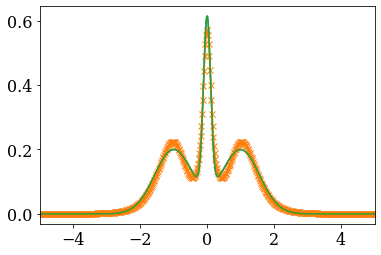

In [30]:
omegas = np.linspace(-10, 10 , 1000)
plt.xlim([-5, 5])
plt.plot(omegas, solver.interpolate(b_smpl, omegas)[:,0,0], marker="")
plt.plot(omegas, solver.interpolate(b_smpl_reconst0, omegas)[:,0,0], marker="x")
plt.plot(omegas, rho(omegas), marker="")

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


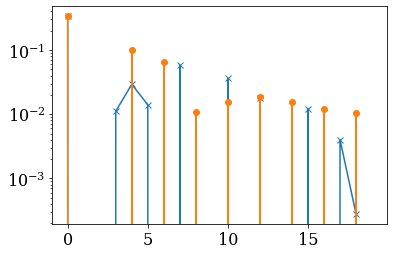

In [ ]:
plt.semilogy(solver.rho_l(b_smpl_reconst0)[::2,0,0], marker="x")
plt.semilogy(rhol[::2], marker="o")
#plt.semilogy(np.abs(gl[::2]- solver.g_l(b_smpl_reconst0)[::2,0,0]), marker="o")


In [ ]:
b_smpl_reconst1 = solver.fit_g_l(gl[:,None,None], 1e-14, b_smpl0=b_smpl)
omegas = np.linspace(-10, 10 , 1000)
plt.xlim([-5, 5])
plt.plot(omegas, solver.interpolate(b_smpl, omegas)[:,0,0], marker="")
plt.plot(omegas, solver.interpolate(b_smpl_reconst1, omegas)[:,0,0], marker="")
plt.plot(omegas, rho(omegas), marker="")

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (500,) and (41,)

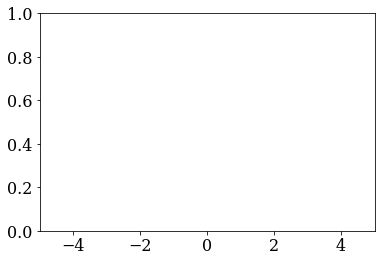

In [ ]:
plt.xlim([-5,5])
plt.plot(solver.smpl_points, b_smpl_reconst[:,0,0] * np.conj(b_smpl_reconst[:,0,0]), marker="o")
plt.plot(omegas, solver.interpolate(b_smpl_reconst, omegas)[:,0,0], marker="")

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


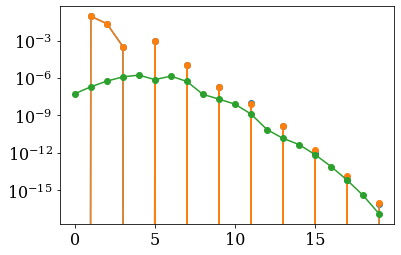

In [ ]:
plt.semilogy(solver.g_l(b_smpl_reconst)[::2,0,0], marker="o")
plt.semilogy(gl[::2], marker="o")
plt.semilogy(np.abs(gl[::2]- solver.g_l(b_smpl_reconst)[::2,0,0]), marker="o")


/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


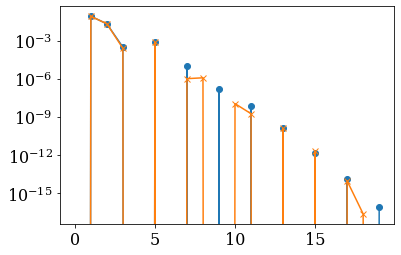

In [ ]:
x_, w_ = leggauss(10000)
x, w = scale_quad(x_, w_, -wmax, wmax)
gl2 = -basis.s * np.einsum('w,w,lw->l', solver.interpolate(b_smpl_reconst, x)[:,0,0], w, basis.v(x))

plt.semilogy(gl[::2], marker="o")
plt.semilogy(gl2[::2], marker="x")

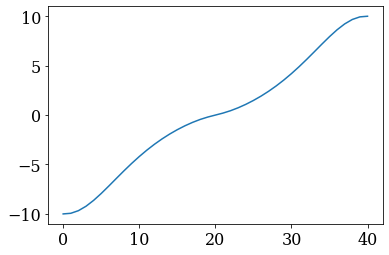

In [ ]:
plt.plot(solver.smpl_points)